# 2013 National Hospital Ambulatory Medical Care Survey - NHAMCS



First of all, import all the essential libraries

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import numpy as np
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from operator import itemgetter
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns

Then import the dataset as ed2013

In [ ]:
ed2013 = pd.read_stata('https://ftp.cdc.gov/pub/health_statistics/nchs/dataset_documentation/nhamcs/stata/ED2013-stata.dta', convert_categoricals=False,
convert_missing=True)

In [ ]:
ed2013

,VMONTH,VDAYR,ARRTIME,WAITTIME,LOV,AGE,AGER,AGEDAYS,RESIDNCE,SEX,...,RX12V3C1,RX12V3C2,RX12V3C3,RX12V3C4,SETTYPE,YEAR,CSTRATM,CPSUM,PATWT,EDWT
0,1,3,0647,33,58,46,4,-7,1,2,...,,,,,3,2013,20113201,100020,2945,.
1,1,3,1841,109,150,56,4,-7,1,2,...,,,,,3,2013,20113201,100020,2945,.
2,1,3,1333,84,198,37,3,-7,1,2,...,,,,,3,2013,20113201,100020,2945,.
3,1,3,1401,159,276,7,1,-7,1,1,...,,,,,3,2013,20113201,100020,2945,.
4,1,4,1947,114,248,53,4,-7,1,1,...,,,,,3,2013,20113201,100020,2945,.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24772,8,1,1925,0,69,27,3,-7,1,2,...,,,,,3,2013,40300000,23,3043,.
24773,8,1,0929,0,106,44,3,-7,1,1,...,,,,,3,2013,40300000,23,3043,.
24774,7,1,0116,0,1363,8,1,-7,1,2,...,,,,,3,2013,40300000,23,3043,.
24775,7,7,1300,0,30,73,5,-7,1,1,...,,,,,3,2013,40300000,23,3043,.


**Data Preprocessing**

In [ ]:
#drop the rows with missing values
ed2013 = ed2013.dropna()

In [ ]:
# impute missing values with the mean
ed2013 = ed2013.fillna(ed2013.mean())

<ipython-input-9-b8827734793d>:2: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  ed2013 = ed2013.fillna(ed2013.mean())


In [ ]:
#take a ook at all the columns
ed2013.columns

Index(['VMONTH', 'VDAYR', 'ARRTIME', 'WAITTIME', 'LOV', 'AGE', 'AGER',
       'AGEDAYS', 'RESIDNCE', 'SEX',
       ...
       'RX12V3C1', 'RX12V3C2', 'RX12V3C3', 'RX12V3C4', 'SETTYPE', 'YEAR',
       'CSTRATM', 'CPSUM', 'PATWT', 'EDWT'],
      dtype='object', length=591)

# Analysis 1 :
I have analyzed if patients from racial minority groups wait longer.

This can help to maintain cultural equality by understanding if there is difference between wait time for different racial groups. It is useful for having the basic human rights to have equal opportunity for the availability of medical care.

In [ ]:
# Separate the data into groups based on RACER column
grouped_data = [ed2013['WAITTIME'][ed2013['RACER'] == racer] for racer in ed2013['RACER'].unique()]

# Perform t-tests for all pairwise comparisons
for i in range(len(grouped_data)):
    for j in range(i + 1, len(grouped_data)):
        racer1 = ed2013['RACER'].unique()[i]
        racer2 = ed2013['RACER'].unique()[j]

        # Assign names to the races as given in the data
        if racer1 == 1:
            racer1_name = "White"
        elif racer1 == 2:
            racer1_name = "Black"
        else:
            racer1_name = "Others"

        if racer2 == 1:
            racer2_name = "White"
        elif racer2 == 2:
            racer2_name = "Black"
        else:
            racer2_name = "Others"

        t_statistic, p_value = ttest_ind(grouped_data[i], grouped_data[j])
        print(f"T-test between {racer1_name} and {racer2_name} races:")
        print(f"T-statistic: {t_statistic.round(5)}")
        print(f"P-value: {p_value}")
        print()

T-test between White and Black races:
T-statistic: -9.46387
P-value: 3.2338227012542342e-21

T-test between White and Others races:
T-statistic: -3.10125
P-value: 0.001929917786361799

T-test between Black and Others races:
T-statistic: 1.05668
P-value: 0.2906941227179418



<ipython-input-12-530c1e7fe464>:16: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(x='RACER_LABEL', y='WAITTIME', data=combined_data, jitter=True, palette=['blue', 'orange', 'green'])


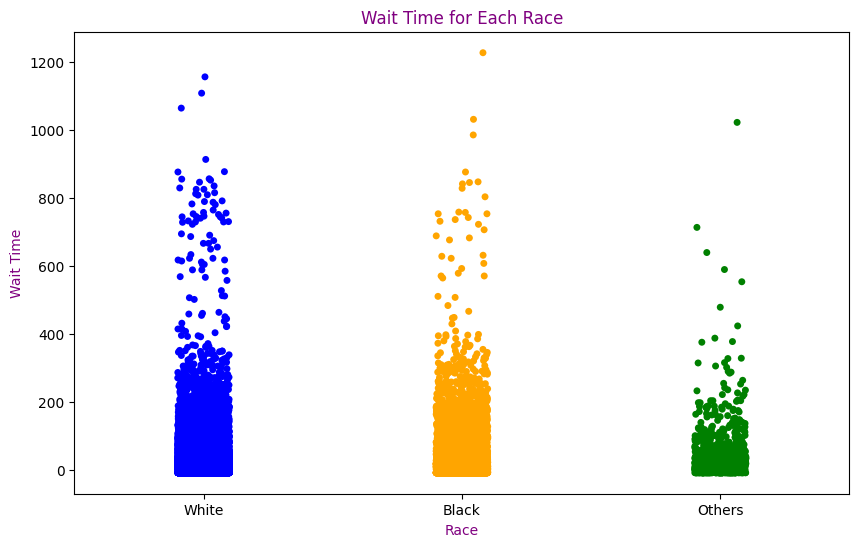

In [ ]:
# Extract data for different races
white = ed2013[ed2013['RACER'] == 1][['RACER', 'WAITTIME']]
black = ed2013[ed2013['RACER'] == 2][['RACER', 'WAITTIME']]
others = ed2013[ed2013['RACER'] == 3][['RACER', 'WAITTIME']]

# Combine data for plotting
combined_data = pd.concat([white, black, others])

# Map numeric race codes to corresponding labels
race_labels = {1: 'White', 2: 'Black', 3: 'Others'}
combined_data['RACER_LABEL'] = combined_data['RACER'].map(race_labels)

# Plot strip plot
plt.figure(figsize=(10, 6))

sns.stripplot(x='RACER_LABEL', y='WAITTIME', data=combined_data, jitter=True, palette=['blue', 'orange', 'green'])

plt.title('Wait Time for Each Race', color = 'purple')
plt.xlabel('Race', color = 'purple')
plt.ylabel('Wait Time', color = 'purple')
plt.show()


The distribution is understood with this stirp plot.

# Analysis 2:
In this analysis, it is concluded if wait times increase during holiday periods with the help of t-test.


In [ ]:
#convert wait time column to numeric data
ed2013['WAITTIME'] = pd.to_numeric(ed2013['WAITTIME'], errors='coerce', downcast='integer')

# Separate holiday and non-holiday data by including rows where VDAYR includes values 1 and 7.
holiday = ed2013[ed2013['VDAYR'].isin([1, 7])]

# Exclude rows where VDAYR is 1 or 2
non_holiday = ed2013[~ed2013['VDAYR'].isin([1, 7])]

#check if any nan(not a number) values are present to cross check
print("NaN Values:")
print(holiday['WAITTIME'].isnull().sum())
print(non_holiday['WAITTIME'].isnull().sum())

NaN Values:
0
0


In [ ]:
# Perform t-test
t_statistic, p_value = ttest_ind(holiday['VDAYR'], non_holiday['VDAYR'])

# Print results
print("T-test Results:")
print(f"T-statistic: {t_statistic}")
print(f"P-value: {p_value}")

# Interpret the results
if (p_value < 0.05).any():  # We can adjust the significance level here as needed (here considering 0.05 which is generally used)
    print("There is a significant difference in average wait times between holiday and non-holiday seasons.")
else:
    print("There is no significant difference in average wait times between holiday and non-holiday seasons.")



T-test Results:
T-statistic: 1.4913463203617037
P-value: 0.13588332546764406
There is no significant difference in average wait times between holiday and non-holiday seasons.


# Analysis 3:
Here, the five most important numeric variables and the five most important categorical variables that can predict how long a patient will wait are found.

Based on that, we can understand the major factors affecting the Wait Time.


In [ ]:
# Replace StataMissingValue with NaN

ed2013_1 = ed2013.apply(pd.to_numeric, errors='coerce')

ed2013_1.replace('StataMissingValue', np.nan, inplace=True)

ed2013_1.fillna(0, inplace=True)

# Separate features (X) and target variable (y)
X = ed2013_1.drop('WAITTIME', axis=1) #features
y = ed2013_1['WAITTIME'] #target variable

# Split the data into training and testing sets with test size as 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the random forest model to the training data

rf = RandomForestClassifier(random_state=0)

rf.fit(X_train, y_train)

# Calculate the accuracy
acc = accuracy_score(y_test, rf.predict(X_test))

# Print the importances per feature

N = dict(zip(X.columns, rf.feature_importances_.round(5)))

print(N)

# Print accuracy
print(f"{acc:.1%} accuracy on test set.")

{'VMONTH': 0.01058, 'VDAYR': 0.00984, 'ARRTIME': 0.02009, 'LOV': 0.02136, 'AGE': 0.01382, 'AGER': 0.00792, 'AGEDAYS': 0.00127, 'RESIDNCE': 0.00211, 'SEX': 0.00427, 'ETHUN': 0.00399, 'ETHIM': 0.00239, 'RACEUN': 0.00534, 'RACER': 0.00385, 'RACERETH': 0.0051, 'ARREMS': 0.00332, 'NOPAY': 0.00054, 'PAYPRIV': 0.00364, 'PAYMCARE': 0.00243, 'PAYMCAID': 0.00348, 'PAYWKCMP': 0.00046, 'PAYSELF': 0.00267, 'PAYNOCHG': 0.00049, 'PAYOTH': 0.00147, 'PAYDK': 0.00138, 'PAYTYPER': 0.00847, 'TEMPF': 0.01349, 'PULSE': 0.01427, 'RESPR': 0.0103, 'BPSYS': 0.01317, 'BPDIAS': 0.01297, 'POPCT': 0.01025, 'ONO2': 0.00311, 'IMMEDR': 0.0092, 'PAINSCALE': 0.01021, 'SEEN72': 0.00315, 'RFV1': 0.01291, 'RFV2': 0.00946, 'RFV3': 0.00569, 'RFV13D': 0.01287, 'RFV23D': 0.00913, 'RFV33D': 0.00565, 'EPISODE': 0.00293, 'INJURY': 0.00317, 'INJR1': 0.0019, 'INJR2': 0.002, 'INJPOISAD': 0.00354, 'INJPOISADR1': 0.00235, 'INJPOISADR2': 0.00239, 'INTENT': 0.00232, 'INJDETR': 0.00446, 'INJDETR1': 0.00274, 'INJDETR2': 0.00302, 'CAUSE1':

In [ ]:
#numerical and categorical data
numerical_columns = ed2013.select_dtypes(include=['number']).columns
categorical_columns = ed2013.select_dtypes(include='object').columns

In [ ]:
from operator import itemgetter
# find top 5 categorical columns to predict wait time
top_categorical_values = {}

for key in N:
    if key in categorical_columns:
        top_categorical_values[key] = N[key]

# Sort the dictionary by values and get the top 5 items
sorted_top_categorical_values = dict(sorted(top_categorical_values.items(), key=itemgetter(1), reverse=True)[:5])

print(sorted_top_categorical_values)

{'ARRTIME': 0.02009, 'DIAG13D': 0.01402, 'RX1CAT1': 0.00949, 'DIAG1': 0.00915, 'DIAG23D': 0.00836}


In [ ]:
# top find top 5 numerical columns to predict wait time
top_num_values = {}

for key in N:
    if key in numerical_columns:
        top_num_values[key] = N[key]

# Sort the dictionary by values and get the top 5 items
sorted_top_num_values = dict(sorted(top_num_values.items(), key=itemgetter(1), reverse=True)[:5])

print(sorted_top_num_values)

{'LOV': 0.02136, 'PATCODE': 0.01566, 'DIAG1R': 0.01481, 'PULSE': 0.01427, 'AGE': 0.01382}
